In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
data = pd.read_csv('/content/drive/MyDrive/Filename_Wed_Jun_12_2024 (2).csv')
data

,Date,"Germany, WHOLESALE, National Average, Wheat (bread making quality), EUR/Kg","Germany, WHOLESALE, National Average, Eggs, EUR/Kg","Germany, WHOLESALE, National Average, Milk (raw), EUR/Kg","Germany, WHOLESALE, National Average, Chicken (whole), EUR/Kg"
0,05/01/2024,0.22602,2.2206,0.4588,4.2416
1,04/01/2024,0.19373,2.3027,0.4588,4.2453
2,03/01/2024,0.18246,2.6033,0.4599,4.2290
3,02/01/2024,0.19378,2.4993,0.4566,4.2200
4,01/01/2024,0.21720,2.4516,0.4589,4.2132
...,...,...,...,...,...
396,05/01/1991,0.17354,NaN,NaN,1.4063
397,04/01/1991,0.16925,NaN,NaN,1.4145
398,03/01/1991,0.16580,NaN,NaN,1.4046
399,02/01/1991,0.16453,NaN,NaN,1.3966


Конвертирање на колоната 'Date' во формат datetime

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')


Преименување на колоните за полесен пристап

In [ ]:
data.columns = ['Date', 'Wheat_EUR_Kg', 'Eggs_EUR_Kg', 'Milk_EUR_Kg', 'Chicken_EUR_Kg']

Проверуваме дали има Missing Values, со кои што понатака треба да се справиме

In [ ]:
data.isnull().sum()

Date                0
Wheat_EUR_Kg        2
Eggs_EUR_Kg        73
Milk_EUR_Kg       169
Chicken_EUR_Kg      2
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            401 non-null    datetime64[ns]
 1   Wheat_EUR_Kg    399 non-null    float64       
 2   Eggs_EUR_Kg     328 non-null    float64       
 3   Milk_EUR_Kg     232 non-null    float64       
 4   Chicken_EUR_Kg  399 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 15.8 KB


Со помош на bar и heatmap гледаме дали има некаква поврзаност на вредностите кои недостасуваат

<Axes: >

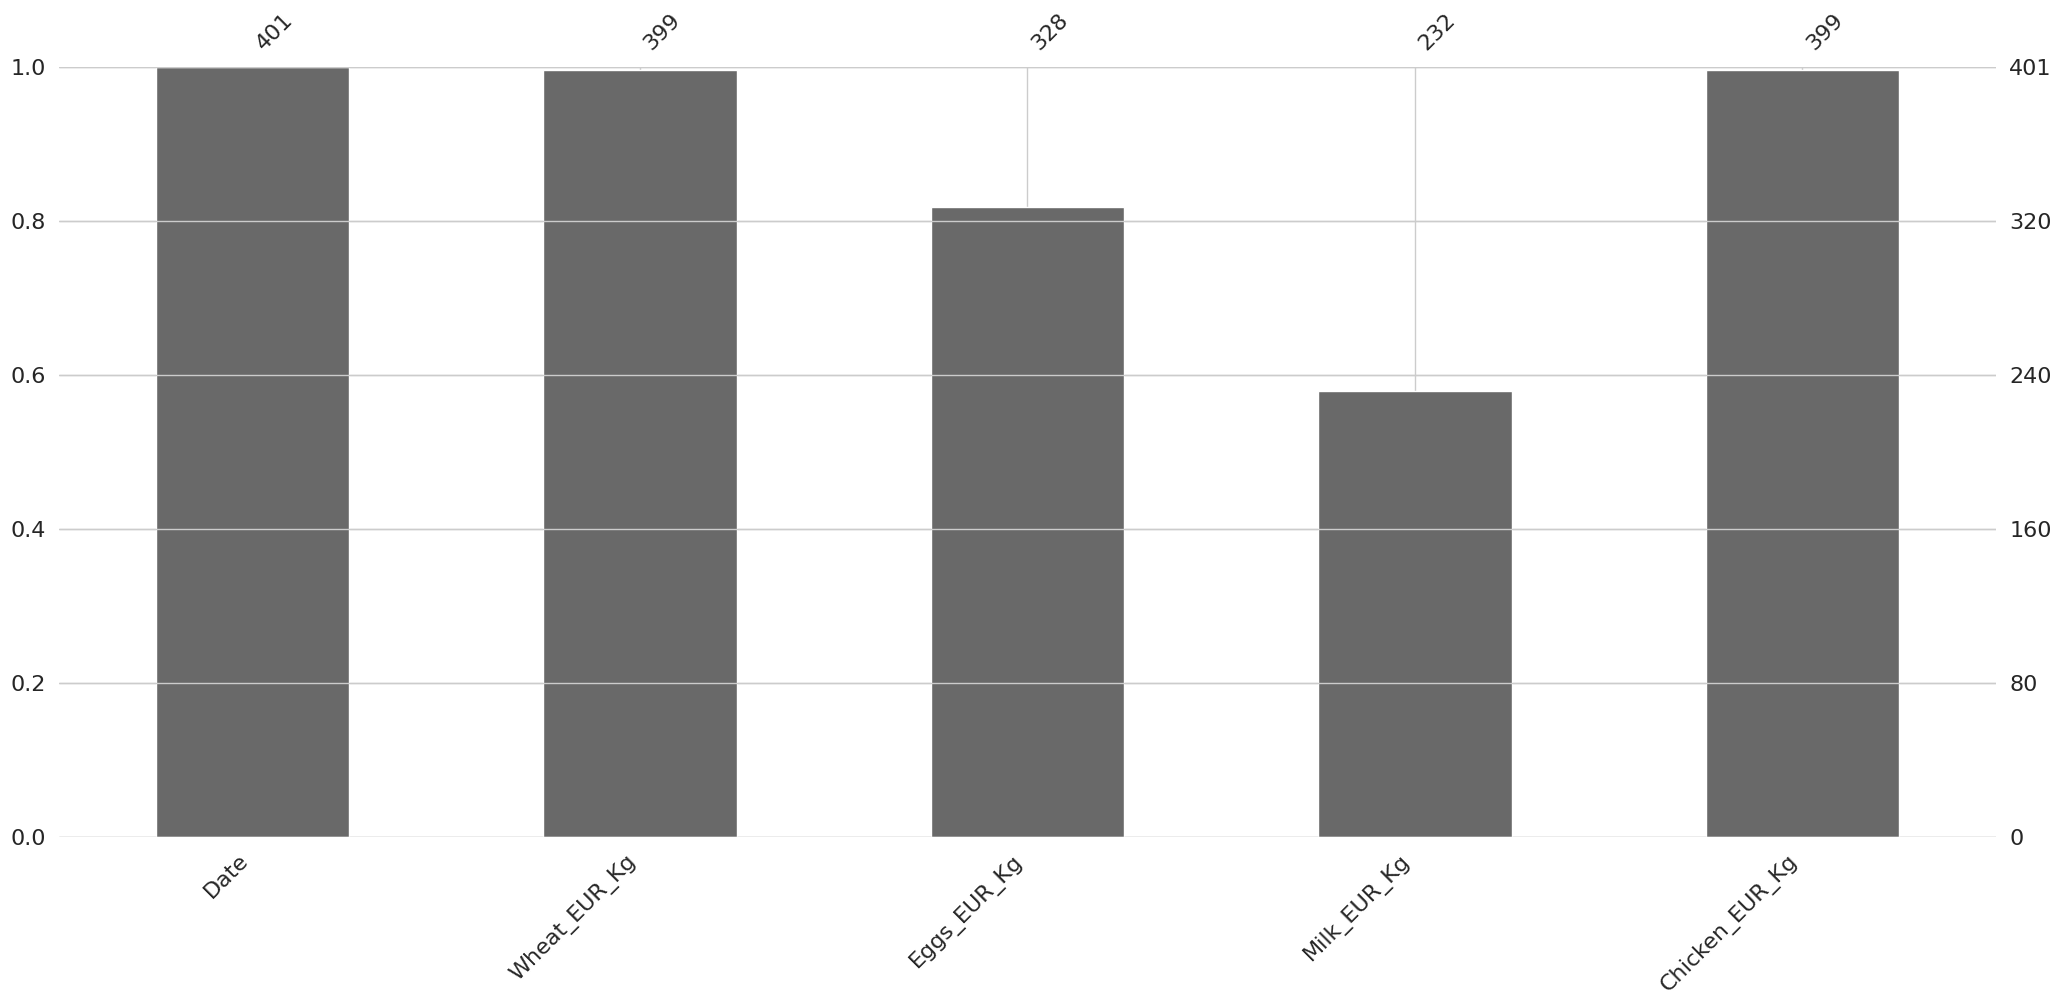

In [ ]:
import missingno as msno
msno.bar(data)

<Axes: >

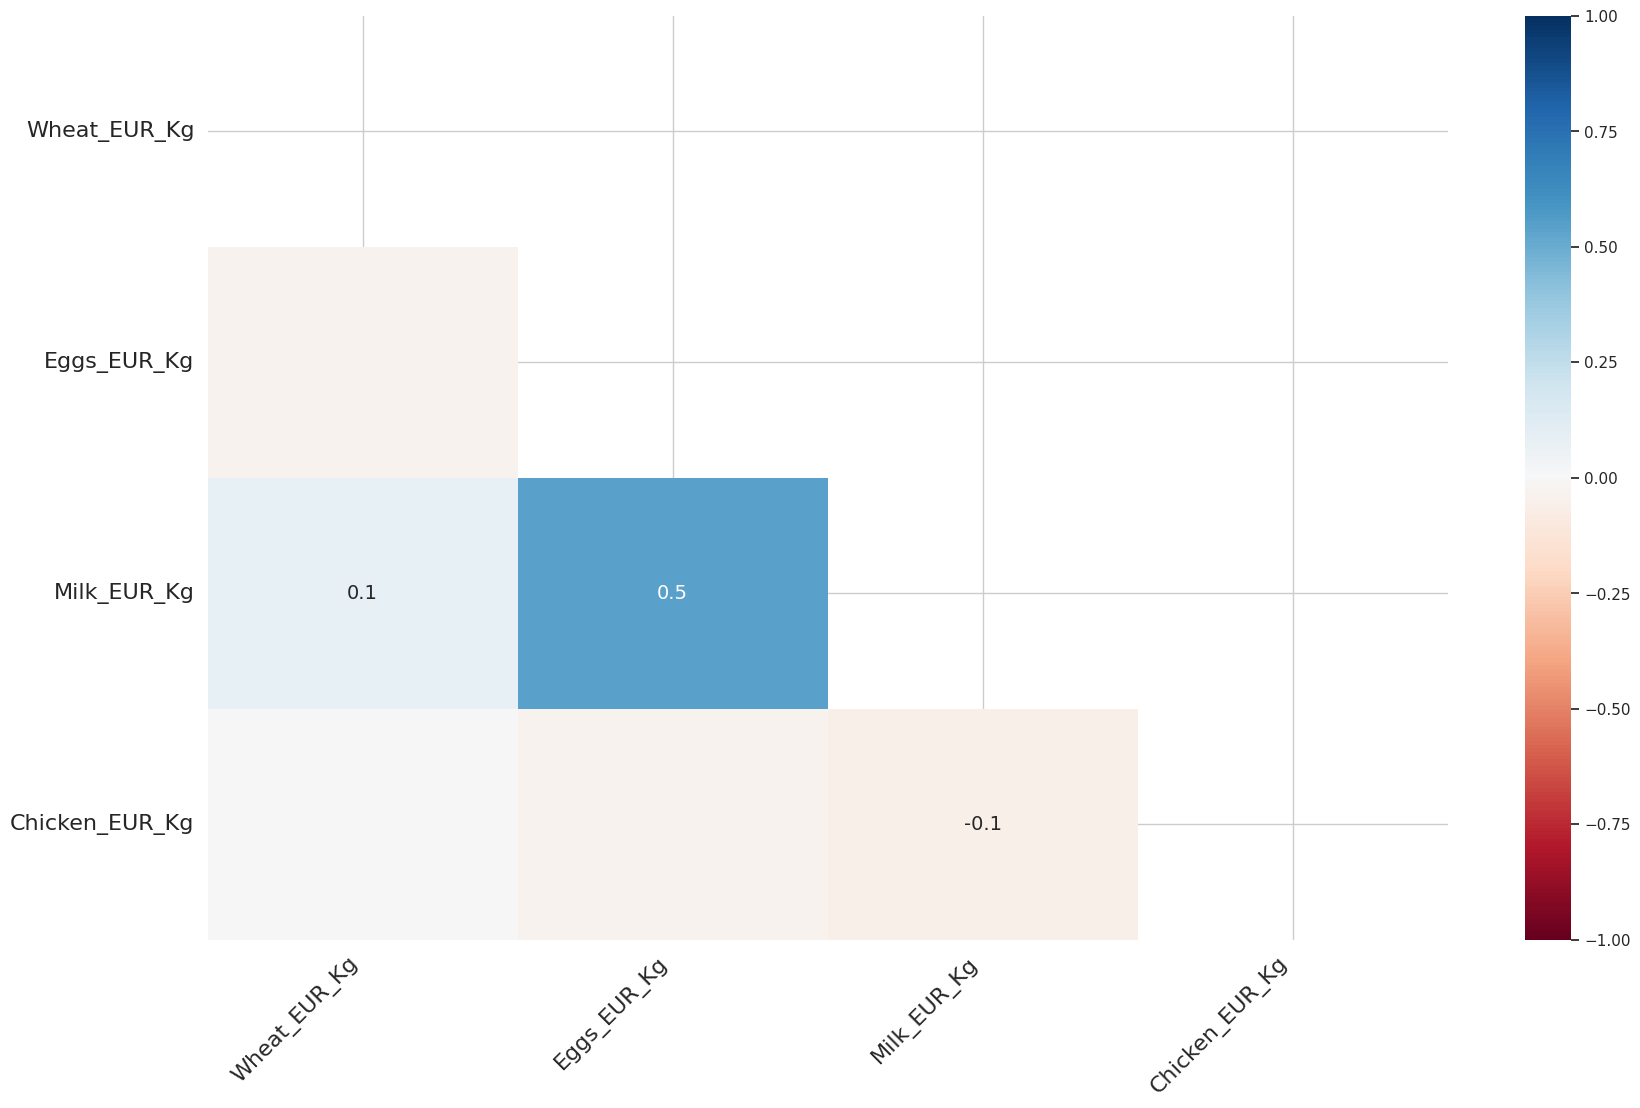

In [ ]:
msno.heatmap(data)

In [ ]:
data['Year'] = data['Date'].dt.year

In [ ]:
from sklearn.impute import KNNImputer
imp=KNNImputer(n_neighbors=2)
data['Wheat_EUR_Kg']=imp.fit_transform(data['Wheat_EUR_Kg'].to_numpy().reshape(-1,1))
data['Eggs_EUR_Kg']=imp.fit_transform(data['Eggs_EUR_Kg'].to_numpy().reshape(-1,1))
data['Milk_EUR_Kg']=imp.fit_transform(data['Milk_EUR_Kg'].to_numpy().reshape(-1,1))
data['Chicken_EUR_Kg']=imp.fit_transform(data['Chicken_EUR_Kg'].to_numpy().reshape(-1,1))

In [ ]:
data.isnull().sum()

Date              0
Wheat_EUR_Kg      0
Eggs_EUR_Kg       0
Milk_EUR_Kg       0
Chicken_EUR_Kg    0
Year              0
dtype: int64

In [ ]:
print(data.describe())

                                Date  Wheat_EUR_Kg  Eggs_EUR_Kg  Milk_EUR_Kg  \
count                            401    401.000000   401.000000   401.000000   
mean   2007-03-24 23:52:49.077306624      0.168546     1.168034     0.345770   
min              1991-01-01 00:00:00      0.102290     0.541900     0.220000   
25%              1999-01-05 00:00:00      0.127110     0.933600     0.332500   
50%              2007-01-09 00:00:00      0.157960     1.148000     0.345770   
75%              2016-01-01 00:00:00      0.191350     1.196400     0.346500   
max              2024-01-05 00:00:00      0.407250     2.692600     0.617200   
std                              NaN      0.053382     0.393546     0.057235   

       Chicken_EUR_Kg         Year  
count      401.000000   401.000000  
mean         2.149588  2007.211970  
min          1.195500  1991.000000  
25%          1.432200  1999.000000  
50%          2.265000  2007.000000  
75%          2.660000  2016.000000  
max          4.24530

In [ ]:
sns.set(style="whitegrid")

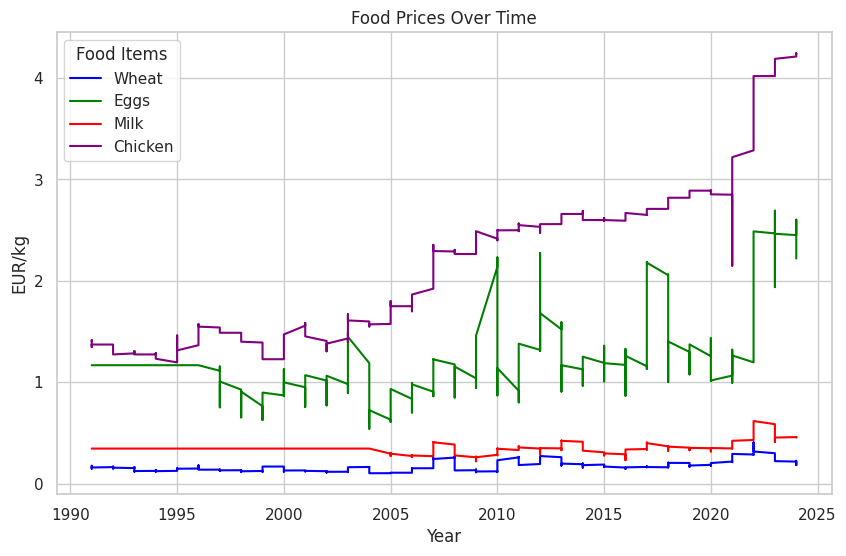

In [ ]:
fig=plt.figure(figsize=(10, 6))
plt.title('Food Prices Over Time')
plt.xlabel('Year')
plt.ylabel('EUR/kg')
plt.plot(data['Year'], data['Wheat_EUR_Kg'], label='Wheat', color='blue')
plt.plot(data['Year'], data['Eggs_EUR_Kg'], label='Eggs', color='green')
plt.plot(data['Year'], data['Milk_EUR_Kg'], label='Milk', color='red')
plt.plot(data['Year'], data['Chicken_EUR_Kg'], label='Chicken', color='purple')

plt.legend(title='Food Items', loc='upper left')
plt.show()

Можеме да креираме bar за да ги визуализираме распределбите на просечните цени на различните видови храна по година

In [ ]:
yearly_avg_prices = data.groupby('Year').mean().reset_index()

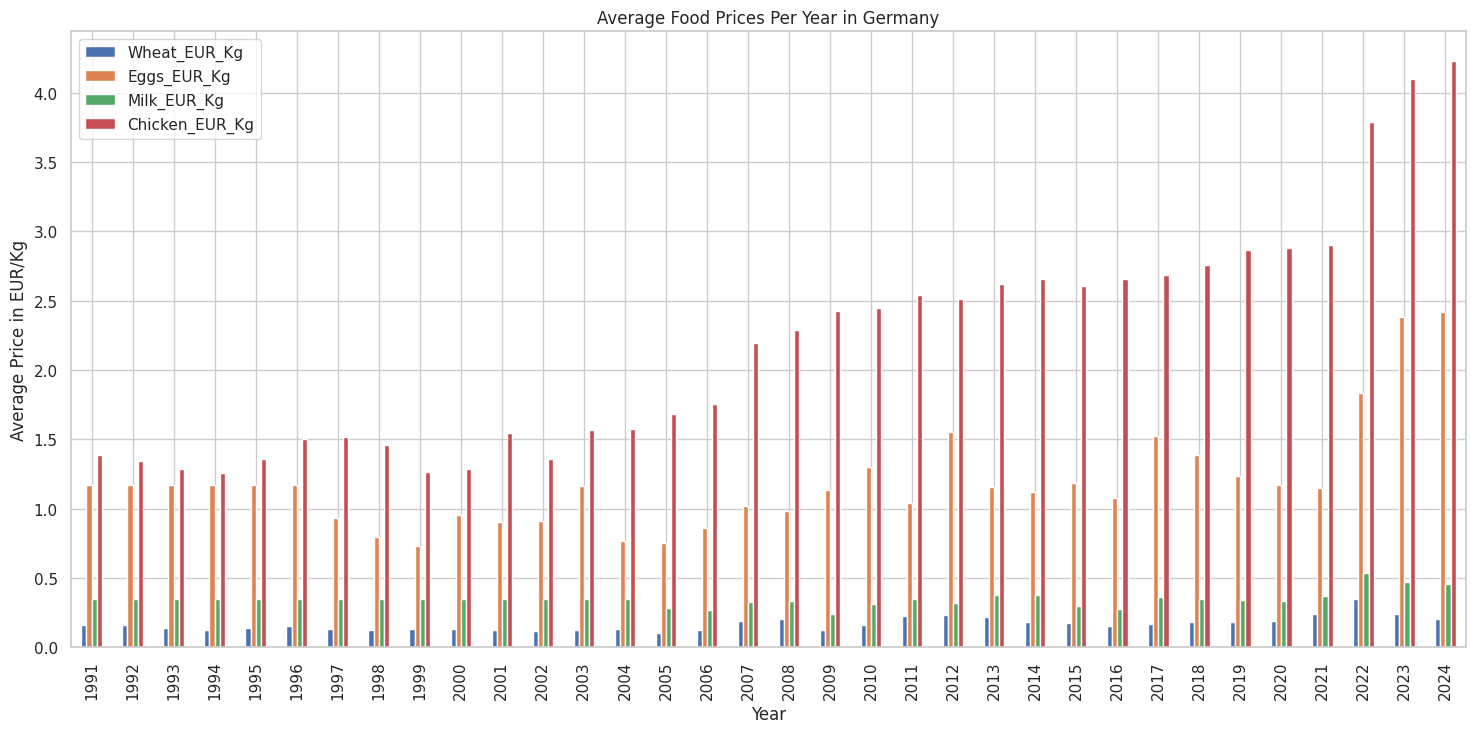

In [ ]:
def plot_bar_chart(data, columns, title):
    data.plot(x='Year', y=columns, kind='bar', figsize=(18, 8))
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Average Price in EUR/Kg')
    plt.legend()
    plt.show()

plot_bar_chart(yearly_avg_prices, ['Wheat_EUR_Kg', 'Eggs_EUR_Kg', 'Milk_EUR_Kg', 'Chicken_EUR_Kg'], 'Average Food Prices Per Year in Germany')

Корелациона матрица за приказ на врските меѓу цените на прехрамбените продукти.

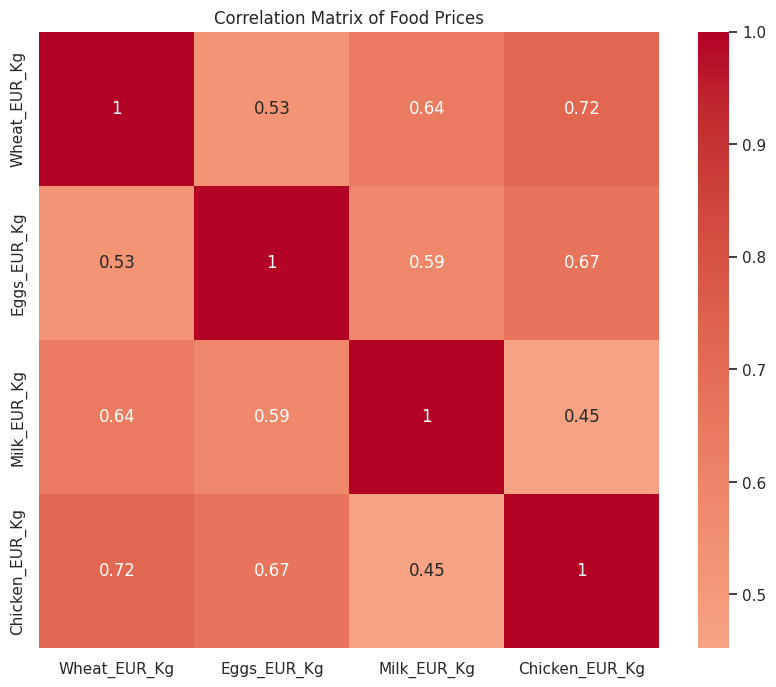

In [ ]:
def plot_correlation_matrix(data, columns, title):
    plt.figure(figsize=(10, 8))
    correlation_matrix = data[columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title(title)
    plt.show()

plot_correlation_matrix(data, ['Wheat_EUR_Kg', 'Eggs_EUR_Kg', 'Milk_EUR_Kg', 'Chicken_EUR_Kg'], 'Correlation Matrix of Food Prices')

Функција за тренинг и евалуација на модели за дадена целна променлива

Поделба на датасетот на тренинг и тест сетови

Иницијализација на моделите

Обука на моделите и евалуација

In [ ]:
def train_and_evaluate(target):
    X = data.drop(columns=[target, 'Date'])
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {
            "Mean Squared Error": mse,
            "R-squared": r2
        }
    return results

Подготовка на податоците за LSTM моделот

In [1]:
def create_lstm_data(data, target, time_steps=3):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].drop(columns=[target, 'Date']).values)
        y.append(data.iloc[i + time_steps][target])
    return np.array(X), np.array(y)

Тренинг и евалуација на LSTM моделот

In [ ]:
def train_and_evaluate_lstm(target, time_steps=3, epochs=50, batch_size=16):
    X, y = create_lstm_data(data, target, time_steps)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(time_steps, X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results = {
        "Mean Squared Error": mse,
        "R-squared": r2
    }
    return results

Таргети за предвидување, колоните кои ќе ги предаваме на моделите за предвидување

In [ ]:
targets = ['Wheat_EUR_Kg', 'Eggs_EUR_Kg', 'Milk_EUR_Kg', 'Chicken_EUR_Kg']

Тренинг и евалуација за сите таргети

In [ ]:
all_results = {}
for target in targets:
    all_results[target] = train_and_evaluate(target)
    all_results[target]['LSTM'] = train_and_evaluate_lstm(target)

3/3 [==============================] - 0s 6ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 3ms/step


3/3 [==============================] - 0s 5ms/step


Прикажување на резултатите

In [ ]:
for target, results in all_results.items():
    print(f"\nResults for {target}:")
    for model_name, metrics in results.items():
        print(f"{model_name} -> MSE: {metrics['Mean Squared Error']}, R2 score: {metrics['R-squared']}")


Results for Wheat_EUR_Kg:
Linear Regression -> MSE: 0.0012280157028432658, R2 score: 0.5970037290914103
Random Forest -> MSE: 0.00033678404150791935, R2 score: 0.8894780314983173
Gradient Boosting -> MSE: 0.00026715632158086936, R2 score: 0.912327667229767
CatBoost -> MSE: 0.00025598551297232675, R2 score: 0.9159935765514907
LSTM -> MSE: 0.018073453749036402, R2 score: -5.85145402665766

Results for Eggs_EUR_Kg:
Linear Regression -> MSE: 0.06612595108471568, R2 score: 0.6377878848724552
Random Forest -> MSE: 0.01798290838080489, R2 score: 0.901496656397253
Gradient Boosting -> MSE: 0.03031153854344922, R2 score: 0.8339652389343015
CatBoost -> MSE: 0.021089985034745257, R2 score: 0.8844773048684508
LSTM -> MSE: 0.1614611410502266, R2 score: 0.12085978042310541

Results for Milk_EUR_Kg:
Linear Regression -> MSE: 0.0017114156730184456, R2 score: 0.5171026609446756
Random Forest -> MSE: 0.00030097051967464247, R2 score: 0.9150774032420489
Gradient Boosting -> MSE: 0.00036753675664660595, 

Визуелизација на резултатите

In [ ]:
results={}
for target in targets:
    results[target] = train_and_evaluate(target)
def plot_evaluation_results(results, metric, title):
    records = []
    for target, models in results.items():
        for model, metrics in models.items():
            records.append((target, model, metrics[metric]))

    results_df = pd.DataFrame(records, columns=['Target', 'Model', metric])

    plt.figure(figsize=(14, 8))
    sns.barplot(x='Target', y=metric, hue='Model', data=results_df)
    plt.title(title)
    plt.xlabel('Target')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

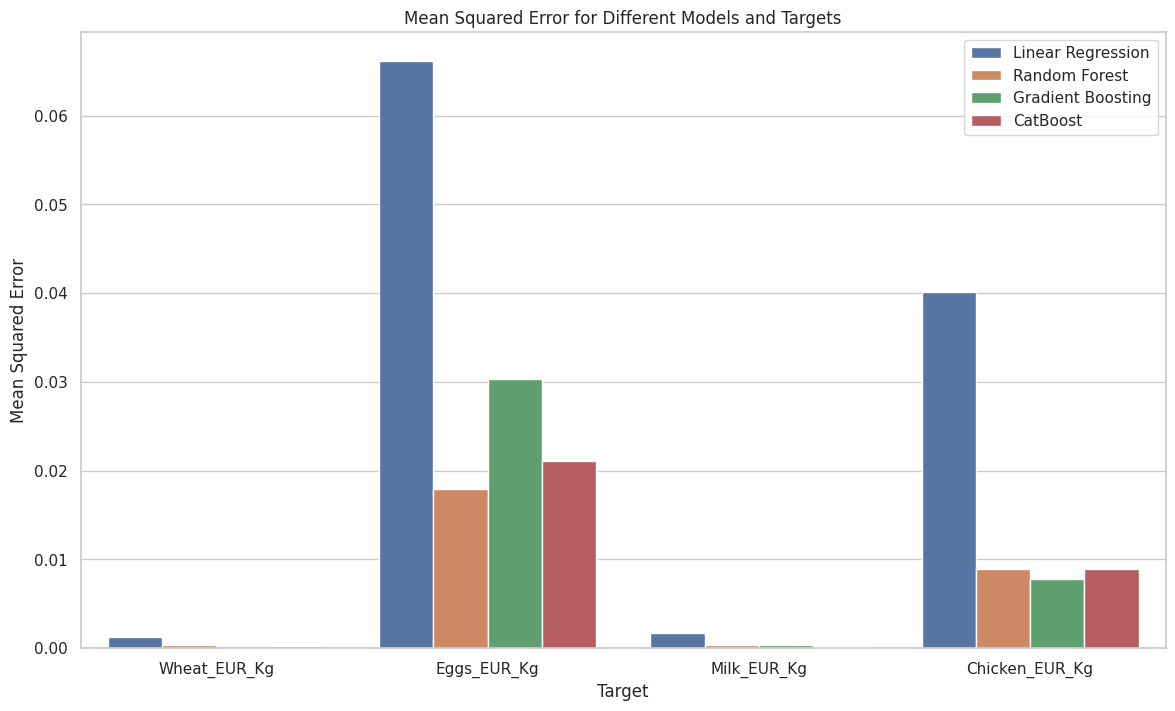

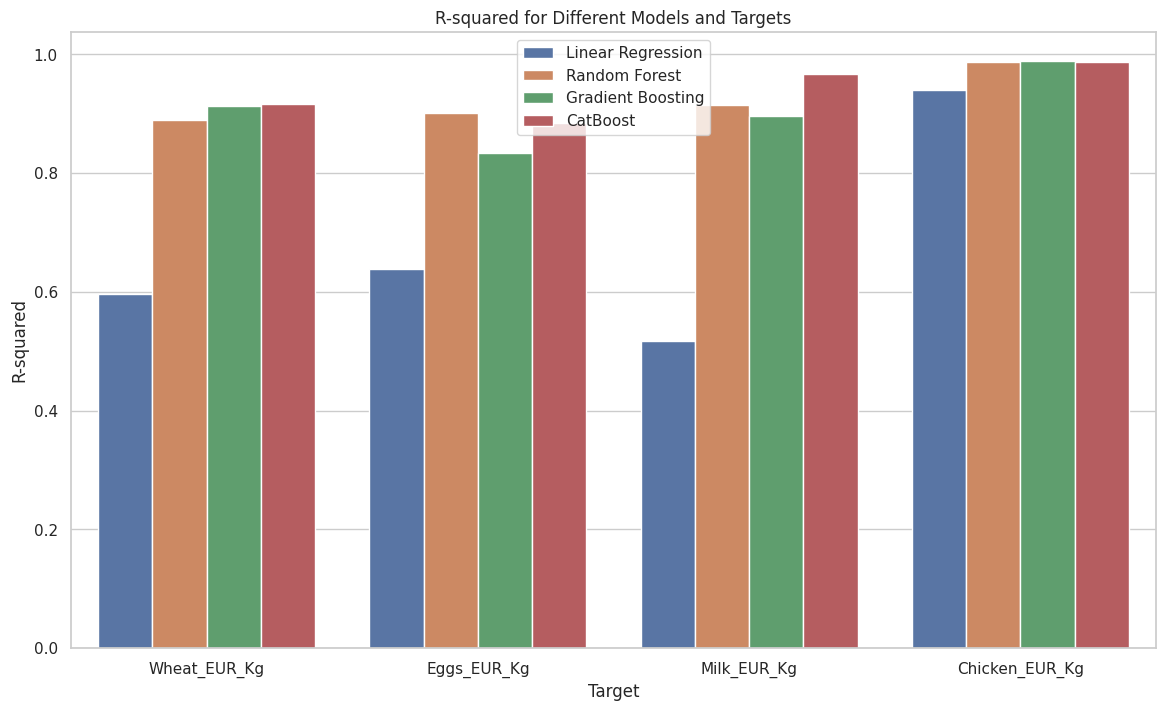

In [ ]:
plot_evaluation_results(all_results, 'Mean Squared Error', 'Mean Squared Error for Different Models and Targets')
plot_evaluation_results(all_results, 'R-squared', 'R-squared for Different Models and Targets')

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.set_index('Date', inplace=True)

In [ ]:
data.drop('Year', axis=1, inplace=True)

In [ ]:
data

,Wheat_EUR_Kg,Eggs_EUR_Kg,Milk_EUR_Kg,Chicken_EUR_Kg
Date,,,,
2024-01-05,0.22602,2.220600,0.45880,4.2416
2024-01-04,0.19373,2.302700,0.45880,4.2453
2024-01-03,0.18246,2.603300,0.45990,4.2290
2024-01-02,0.19378,2.499300,0.45660,4.2200
2024-01-01,0.21720,2.451600,0.45890,4.2132
...,...,...,...,...
1991-01-05,0.17354,1.168034,0.34577,1.4063
1991-01-04,0.16925,1.168034,0.34577,1.4145
1991-01-03,0.16580,1.168034,0.34577,1.4046


За секоја од колоните правиме предвидување користејќи CatBoostRegressor model, за цените во наредните 24 месеци

In [ ]:
def create_lagged_features(series, lag=10):
    df = pd.DataFrame(series)
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df[series.name].shift(i)
    df.dropna(inplace=True)
    return df

Функција за предвидување на идните цени

In [ ]:
def forecast_future_prices(model, series, lag=10, steps=24):
    last_values = series[-lag:].values.reshape(1, -1)
    forecast = []
    for _ in range(steps):
        next_pred = model.predict(last_values)[0]
        forecast.append(next_pred)
        last_values = np.roll(last_values, -1)
        last_values[0, -1] = next_pred
    return forecast

In [ ]:
last_date = data.index[0]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq='M')
future_forecast_df = pd.DataFrame({'Date': future_dates})

За секоја колона од датасетот го повторуваме истиот процес, го делиме множеството на тренирачко и тестирачко, го тренираме моделот CatBoostRegressor на тие множества, па го правиме предвидувањето на идните цени. На крај правиме визуелизација на резултатите и го претставуваме датасетот со идните цени.

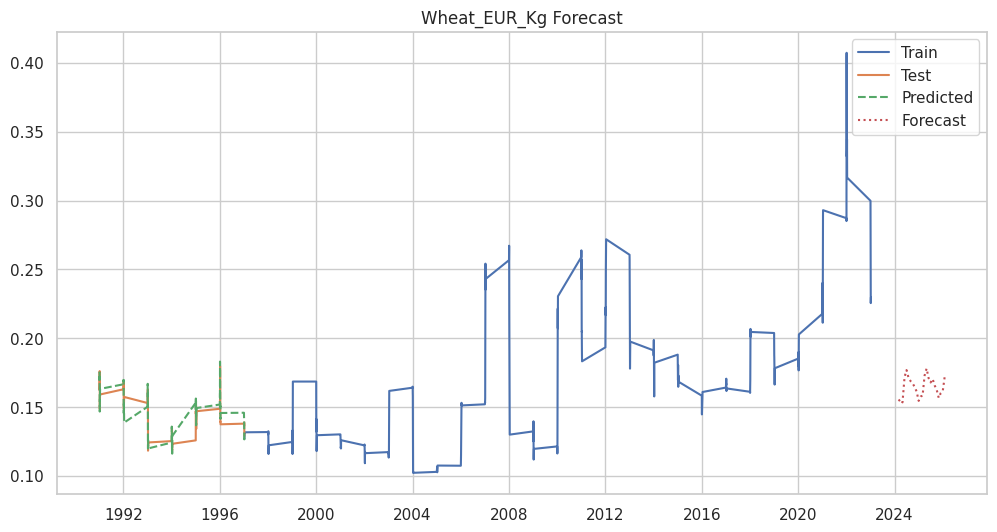

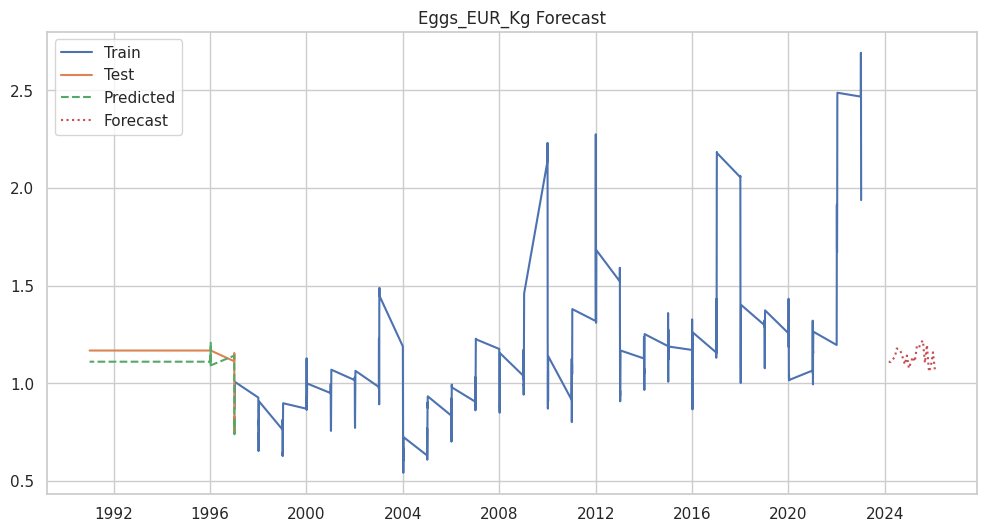

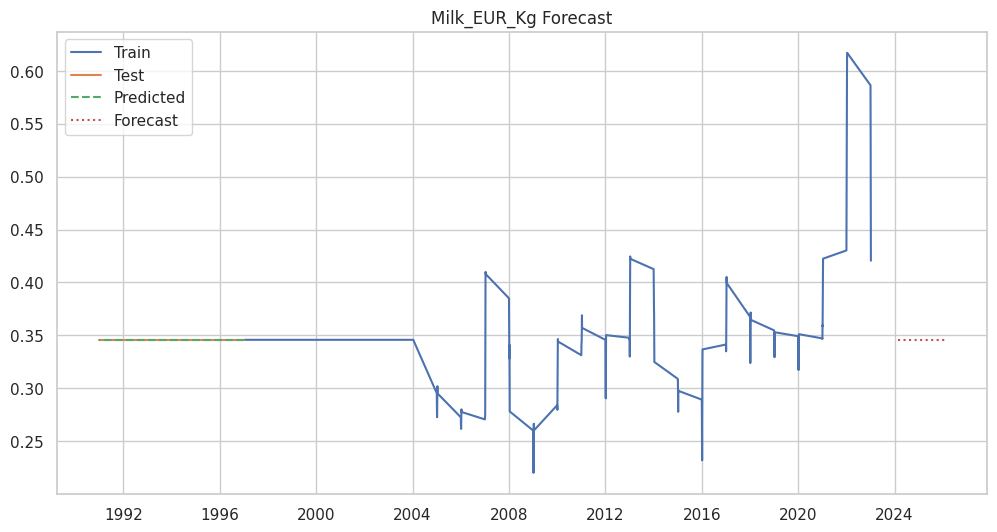

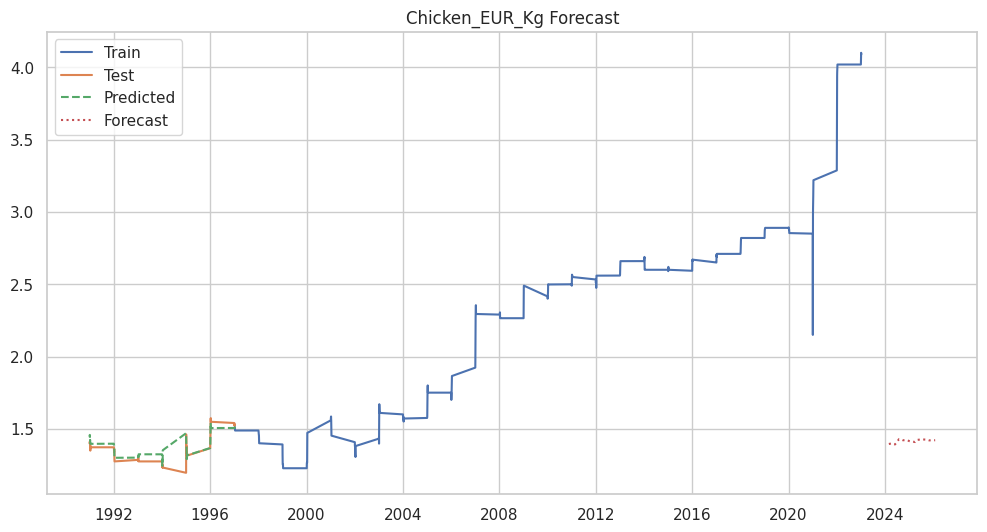

In [ ]:
for column in data.columns:
    series = data[column].dropna()
    lagged_data = create_lagged_features(series, lag=10)
    X = lagged_data.drop(columns=[column])
    y = lagged_data[column]

    train_size = int(len(lagged_data) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = CatBoostRegressor(verbose=0, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    future_forecast = forecast_future_prices(model, series, lag=10, steps=24)
    future_forecast_df[column] = future_forecast

    plt.figure(figsize=(12, 6))
    plt.plot(y_train.index, y_train, label='Train')
    plt.plot(y_test.index, y_test, label='Test')
    plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
    plt.plot(future_dates, future_forecast, label='Forecast', linestyle=':')
    plt.title(f'{column} Forecast')
    plt.legend()
    plt.show()

Датасет со предвидени цени

In [ ]:
future_forecast_df=pd.DataFrame(future_forecast_df)
future_forecast_df

,Date,Wheat_EUR_Kg,Eggs_EUR_Kg,Milk_EUR_Kg,Chicken_EUR_Kg
0,2024-02-29,0.154445,1.110866,0.345737,1.394851
1,2024-03-31,0.155715,1.109428,0.345737,1.397750
2,2024-04-30,0.153434,1.123629,0.345737,1.397457
3,2024-05-31,0.171752,1.133483,0.345737,1.391730
4,2024-06-30,0.176893,1.178282,0.345737,1.407531
5,2024-07-31,0.171166,1.176280,0.345737,1.428152
6,2024-08-31,0.168824,1.160558,0.345737,1.426411
7,2024-09-30,0.167307,1.129959,0.345737,1.420638
8,2024-10-31,0.164621,1.097027,0.345737,1.421361
9,2024-11-30,0.161326,1.142353,0.345737,1.422167
